# NLP Sentiment Analysis

---

## Required Dependencies

In [3]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# !pip install nltk

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


## Environment Setup

In [13]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import Data

### Import JSON Files provided by [![yelp.com](https://raw.githubusercontent.com/tbgrun/tbgrun.github.io/main/assets/analyses/nlp_sentiment_analysis/yelp_badge.png)](https://www.yelp.com) throug [Yelp Open Dataset](https://www.yelp.com/dataset)

In [14]:
business_raw = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)
review_raw = pd.read_json('yelp_dataset/yelp_academic_dataset_review.json', lines=True)

### Data Extraction
* transform date into usable format
* drop unnecessary columns

In [28]:
print(business_raw.head())
business_dropped = business_raw.drop(['latitude', 'longitude', 'review_count', 'categories'], axis=1)
business_dropped.rename(columns={'stars': 'overall_rating'}, inplace=True)

print(review_raw.head())
review_raw['date'] = pd.to_datetime(review_raw['date'])
review_raw['month'] = review_raw['date'].dt.month
review_raw['year'] = review_raw['date'].dt.year
review_dropped = review_raw.drop(['funny', 'cool', 'date'], axis=1)
review_dropped.rename(columns={'stars': 'review_rating'}, inplace=True)

              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.9555

### Merge Data
* merge data frames into a single data frame

In [32]:
df_merged = pd.merge(business_dropped, review_dropped, on='business_id', how='inner')

### Select Data
* Business: First Watch
* Location: Florida (State)
* Review dates: June 2022 through September 2022

#### Spell check 'First Watch'

In [33]:
check_for_firstwatch = 'First Watch' in df_merged['name'].values
count_firstwatch = df_merged['name'].eq('First Watch').sum()
count_firstwatch_variants = df_merged['name'].str.contains(r'\bfirst watch\b', case=False, na=False).sum()
print(f'data frame contains First Watch: {check_for_firstwatch}')
print(f'no variants of "First Watch" found: {count_firstwatch==count_firstwatch_variants}')

data frame contains First Watch: True
no variants of "First Watch" found: True


#### Data extraction

In [72]:
df_raw = df_merged[(df_merged['state'] == 'FL') & 
    (df_merged['name'] == 'First Watch') & 
    (df_merged['year'] == 2019) &
    (df_merged['month'] >= 6) &
    (df_merged['month'] <= 9)
]

#### Add simple identifier for each location

In [100]:
df_raw = df_raw.copy()
df_raw = df_raw.sort_values(by='city', ascending=True)
unique_business_ids = df_raw["business_id"].unique()
business_id_map = {business_id: restaurant_id for restaurant_id, business_id in enumerate(unique_business_ids, start=1)}
df_raw["restaurant_id"] = df_raw["business_id"].map(business_id_map)
df_raw

,business_id,name,address,city,state,postal_code,overall_rating,is_open,attributes,hours,review_id,user_id,review_rating,useful,text,month,year,id,restaurant_id
2135511,c4T4fWfNdnlyOgBN0a5JFA,First Watch,11305 Causeway Blvd,Brandon,FL,33511,4.0,1,"{'Caters': 'False', 'BusinessAcceptsCreditCard...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-14:30', ...",zllH1HGOOmb6VcSzqlD56g,JtXPs3-32bb_knrQretI2w,5,0,I absolutely LOVE this place! You MUST try the...,8,2019,8,1
2135533,c4T4fWfNdnlyOgBN0a5JFA,First Watch,11305 Causeway Blvd,Brandon,FL,33511,4.0,1,"{'Caters': 'False', 'BusinessAcceptsCreditCard...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-14:30', ...",ch_0Jb_7Qzsjlh036dY_oQ,2RIQALEcl9KqEILXjkUiCQ,5,1,Avocado toast is delicious! Comes with 2 baste...,7,2019,8,1
2135583,c4T4fWfNdnlyOgBN0a5JFA,First Watch,11305 Causeway Blvd,Brandon,FL,33511,4.0,1,"{'Caters': 'False', 'BusinessAcceptsCreditCard...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-14:30', ...",FmG517C7t1QRPCKc2byNxQ,MqXrsv6ia_03jMvpat7Rug,1,0,Highly disappointed. Last 2 times I've gone th...,8,2019,8,1
2135506,c4T4fWfNdnlyOgBN0a5JFA,First Watch,11305 Causeway Blvd,Brandon,FL,33511,4.0,1,"{'Caters': 'False', 'BusinessAcceptsCreditCard...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-14:30', ...",G9aMcSZhEMhy5JtMxjeWxw,9K7fjBiuWQan43eeZmc5pA,5,0,Back again for some good and delicious breakfa...,7,2019,8,1
2135499,c4T4fWfNdnlyOgBN0a5JFA,First Watch,11305 Causeway Blvd,Brandon,FL,33511,4.0,1,"{'Caters': 'False', 'BusinessAcceptsCreditCard...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-14:30', ...",VNS9dlSG0SFzcYzXyT-h-A,nJiUD-zqlXm8vyzzopnOIw,5,0,"Never really been a ""brunch"" guy, but First Wa...",7,2019,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649971,I7SkoqN88fpKagzKA059Fw,First Watch,1648 Bruce B Downs Blvd,Wesley Chapel,FL,33544,4.0,1,"{'RestaurantsGoodForGroups': 'True', 'Caters':...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-14:30', ...",g1RDs7djJtpcl-mb6X6xgQ,5tdxtCFmF1JwiczTsVL94Q,5,0,First Watch is my favorite place for breakfast...,8,2019,5,16
1649970,I7SkoqN88fpKagzKA059Fw,First Watch,1648 Bruce B Downs Blvd,Wesley Chapel,FL,33544,4.0,1,"{'RestaurantsGoodForGroups': 'True', 'Caters':...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-14:30', ...",g45wnADMjEW9luIj2rLDeg,F4fBEJriDP8DJx28GpweZA,5,0,I've been going to First Watch for a while now...,6,2019,5,16
1650108,I7SkoqN88fpKagzKA059Fw,First Watch,1648 Bruce B Downs Blvd,Wesley Chapel,FL,33544,4.0,1,"{'RestaurantsGoodForGroups': 'True', 'Caters':...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-14:30', ...",Ali0-i2IpCLiN8kehqq-Tw,yRfMyHl6EtflkYkmz7myOA,1,1,"this was horrible service and food, first of a...",8,2019,5,16
1650014,I7SkoqN88fpKagzKA059Fw,First Watch,1648 Bruce B Downs Blvd,Wesley Chapel,FL,33544,4.0,1,"{'RestaurantsGoodForGroups': 'True', 'Caters':...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-14:30', ...",rUlOYse63wNsrrxxj0cbvw,XShxYd1VKHjH2XxCSe-eMQ,5,1,Never disappointed with First Watch. This is a...,8,2019,5,16


#### Generate overview of id's with corresponding location

In [107]:
location_overview = df_raw[['restaurant_id', 'address', 'city']].drop_duplicates()
location_overview

,restaurant_id,address,city
2135511,1,11305 Causeway Blvd,Brandon
763610,2,2539 Countryside Blvd,Clearwater
1823195,3,"5310 East Bay Dr, Ste 100",Clearwater
6971400,4,"13200 Seminole Blvd, Ste 201",Largo
6969899,5,23685 State Road 54,Lutz
4512263,6,"3240 Redeemer Way, Ste E-3",New Port Richey
105694,7,3691 Tampa Rd,Oldsmar
1870194,8,35146 US Hwy 19 N,Palm Harbor
1064808,9,"13013 US Hwy 301, Ste C",Riverview
244378,10,1345 4th St N,St. Petersburg


## EDA and Data Wrangling

In [102]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 2135511 to 1650109
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   business_id     244 non-null    object 
 1   name            244 non-null    object 
 2   address         244 non-null    object 
 3   city            244 non-null    object 
 4   state           244 non-null    object 
 5   postal_code     244 non-null    object 
 6   overall_rating  244 non-null    float64
 7   is_open         244 non-null    int64  
 8   attributes      244 non-null    object 
 9   hours           244 non-null    object 
 10  review_id       244 non-null    object 
 11  user_id         244 non-null    object 
 12  review_rating   244 non-null    int64  
 13  useful          244 non-null    int64  
 14  text            244 non-null    object 
 15  month           244 non-null    int32  
 16  year            244 non-null    int32  
 17  id              244 non-null  

In [103]:
columns = df_raw.shape
uniques = df_raw['text'].nunique()
print(f'only unique text entries in the data frame: {uniques==columns[0]}')

only unique text entries in the data frame: True


In [104]:
df_raw['city'].value_counts()

city
Tampa              48
St. Petersburg     42
Wesley Chapel      27
Riverview          24
Clearwater         22
Lutz               20
Oldsmar            15
New Port Richey    12
Brandon            12
Largo              11
Palm Harbor        11
Name: count, dtype: int64

In [105]:
ratings = df_raw.groupby('restaurant_id')['review_rating'].agg(
    min_rating='min',
    max_rating='max',
    median_rating='median',
    mad=lambda x: abs(x-x.median()).median(),
    ).reset_index()
n = df_raw['restaurant_id'].value_counts()
rating_overview = pd.merge(ratings, n, on='restaurant_id', how='inner')
rating_overview

,restaurant_id,min_rating,max_rating,median_rating,mad,count
0,1,1,5,5.0,0.0,12
1,2,1,5,5.0,0.0,10
2,3,1,5,5.0,0.0,12
3,4,2,5,5.0,0.0,11
4,5,1,5,4.0,1.0,20
5,6,1,5,5.0,0.0,12
6,7,1,5,5.0,0.0,15
7,8,2,5,5.0,0.0,11
8,9,2,5,5.0,0.0,24
9,10,2,5,4.5,0.5,32


#### Distributions

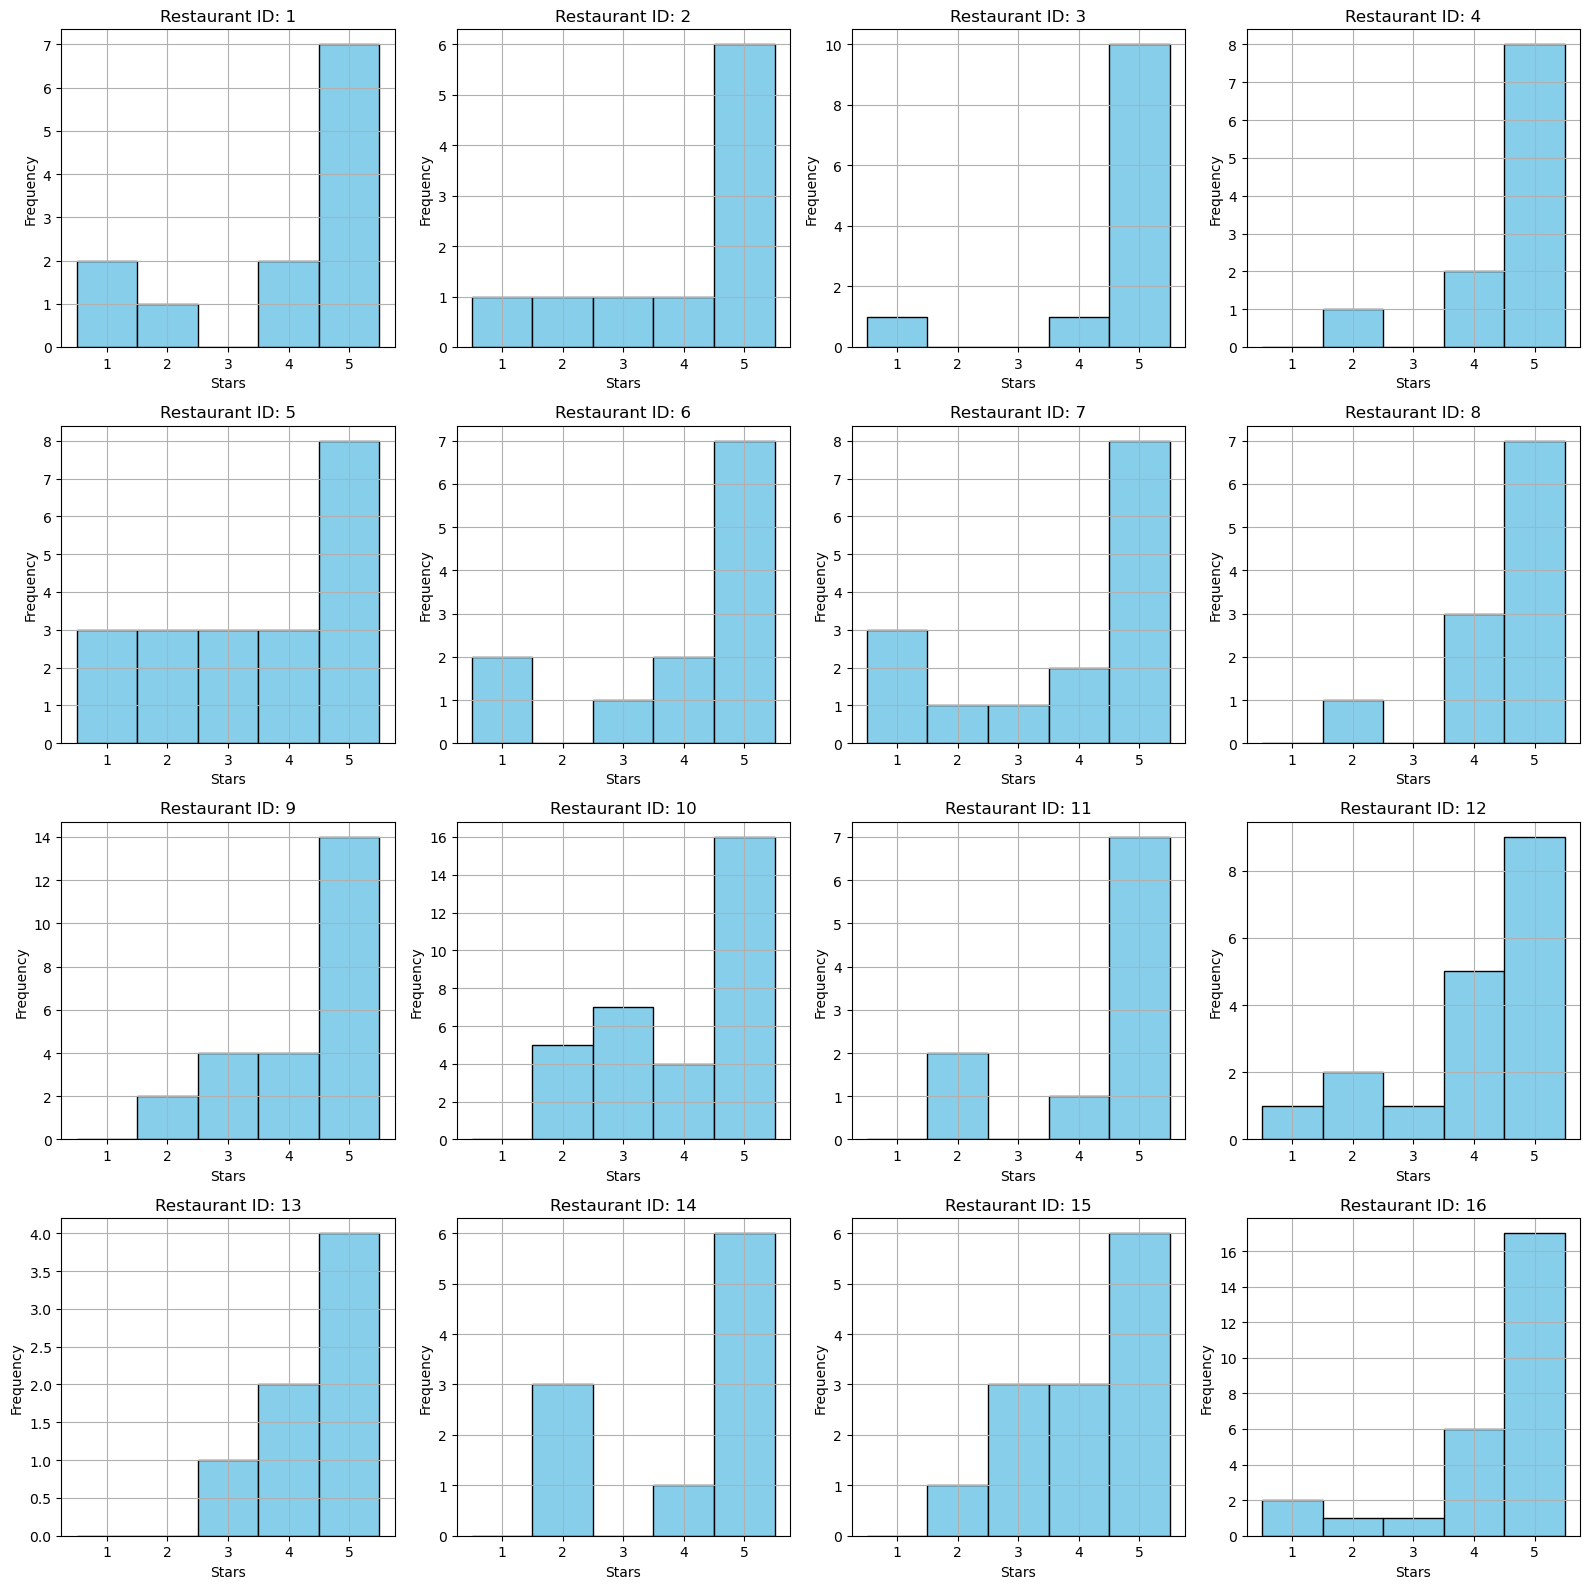

In [112]:
grouped = df_raw.groupby("restaurant_id")

# Create a 4x4 grid for subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))  # Adjust figsize for better readability
axes = axes.flatten()  # Flatten the 4x4 array of axes for easy iteration

# Loop through each group and plot on its respective subplot
for ax, (id, group) in zip(axes, grouped):
    group["review_rating"].hist(ax=ax, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color="skyblue", edgecolor="black")
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_title(f"Restaurant ID: {id}")
    ax.set_xlabel("Stars")
    ax.set_ylabel("Frequency")

# Turn off unused subplots
for ax in axes[len(grouped):]:
    ax.axis("off")

# Adjust layout
plt.tight_layout()
plt.show()